In [215]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [216]:
import numpy as np
import pandas as pd
import datetime as dt



# Reflect Tables into SQLAlchemy ORM

In [217]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [218]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)
inspector.get_table_names()
conn = engine.connect()

In [219]:
# reflect an existing database into a new model
measurements_df = pd.read_sql("SELECT * FROM measurement", engine)
stations_df = pd.read_sql("SELECT * FROM station", engine)
combined_df = measurements_df.merge(stations_df, on='station')
# reflect the tables
Base = automap_base()
Base.prepare(autoload_with=engine)

In [220]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [221]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [222]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [223]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

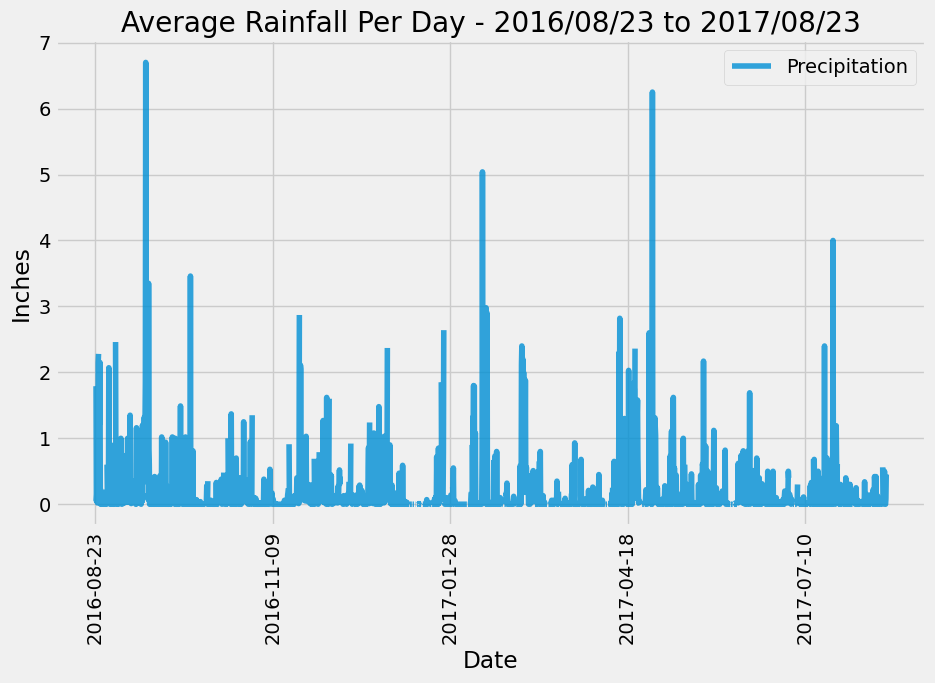

In [235]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_query_df = pd.DataFrame(session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all())
last_year_query_df = last_year_query_df.set_index('date')

# Sort the dataframe by date
last_year_query_df = last_year_query_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
ax = last_year_query_df.plot(title='Average Rainfall Per Day - 2016/08/23 to 2017/08/23', alpha=0.8, figsize=(10,6),rot=90)
ax.set_ylabel('Inches')
ax.set_xlabel('Date')
ax.legend(['Precipitation'])
plt.show()



In [225]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_query_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [226]:
# Design a query to calculate the total number stations in the dataset
number_stations = session.query(Measurement.station).distinct().count()
number_stations

9

In [236]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_station = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [237]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
low_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(f'Most active station: {most_active_station}. Lowest Temperature: {low_temp}, Highest Temperature: {high_temp}, Average Temperature: {avg_temp}.')

Most active station: ('USC00519281',). Lowest Temperature: [(85.0,)], Highest Temperature: [(85.0,)], Average Temperature: [(71.66378066378067,)].


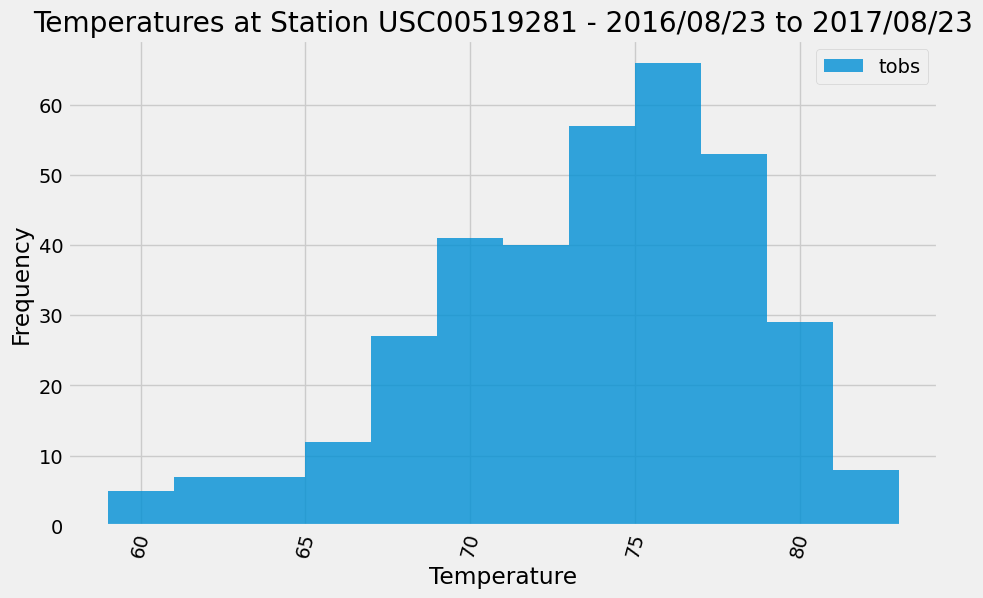

In [241]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_station_df = pd.DataFrame(session.query(Measurement.tobs).filter(Measurement.date >= query_date).filter(Measurement.station == 'USC00519281').all())

ax = last_year_station_df.plot.hist(title='Temperatures at Station USC00519281 - 2016/08/23 to 2017/08/23', alpha=0.8, figsize=(10,6),rot=75,bins=12)
ax.set_ylabel('Frequency')
ax.set_xlabel('Temperature')
plt.show()

# Close session

In [230]:
# Close Session
session.close()